Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

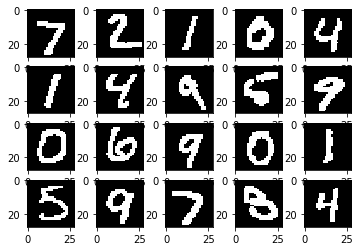

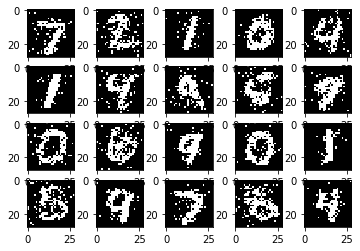

In [1]:
"""
예제 3-1: 이진 입력 RBM을 MNIST 데이터에 적용
"""

# 필요한 라이브러리를 불러들임
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST 파일 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

# 학습관련 매개변수 설정
n_input      = 784
n_hidden    = 500
display_step = 1
num_epochs = 10 
batch_size = 256 
lr         = tf.constant(0.001, tf.float32)

# 입력, 가중치 및 편향을 정의함
x  = tf.placeholder(tf.float32, [None, n_input], name="x") 
W  = tf.Variable(tf.random_normal([n_input, n_hidden], 0.01), name="W") 
b_h = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="b_h")) 
b_i = tf.Variable(tf.zeros([1, n_input],  tf.float32, name="b_i")) 

# 확률을 이산 상태, 즉 0과 1로 변환함 
def binary(probs):
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))
          
# Gibbs 표본추출 단계
def cd_step(x_k):
    h_k = binary(tf.sigmoid(tf.matmul(x_k, W) + b_h)) 
    x_k = binary(tf.sigmoid(tf.matmul(h_k, tf.transpose(W)) + b_i))
    return x_k

# 표본추출 단계 실행     
def cd_gibbs(k,x_k):
    for i in range(k):
        x_out = cd_step(x_k) 
# k 반복 후에 깁스 표본을 반환함
    return x_out

# CD-2 알고리즘
# 1. 현재 입력값을 기반으로 깁스 표본추출을 통해 새로운 입력값 x_s를 구함
# 2. 새로운 x_s를 기반으로 새로운 은닉노드 값 act_h_s를 구함    
x_s = cd_gibbs(2,x) 
act_h_s = tf.sigmoid(tf.matmul(x_s, W) + b_h) 

# 입력값이 주어질 때 은닉노드 값 act_h를 구함
act_h = tf.sigmoid(tf.matmul(x, W) + b_h) 
# 은닉노드 값이 주어질 때 입력값을 추출함
_x = binary(tf.sigmoid(tf.matmul(act_h, tf.transpose(W)) + b_i))

# 경사 하강법을 이용한 가중치 및 편향 업데이트 
W_add  = tf.multiply(lr/batch_size, tf.subtract(tf.matmul(tf.transpose(x), act_h), \
          tf.matmul(tf.transpose(x_s), act_h_s)))
bi_add = tf.multiply(lr/batch_size, tf.reduce_sum(tf.subtract(x, x_s), 0, True))
bh_add = tf.multiply(lr/batch_size, tf.reduce_sum(tf.subtract(act_h, act_h_s), 0, True))
updt = [W.assign_add(W_add), b_i.assign_add(bi_add), b_h.assign_add(bh_add)]

# 텐서플로 그래프 실행
with tf.Session() as sess:
    # 모형의 변수들을 초기화하기
    init = tf.global_variables_initializer()
    sess.run(init)
    
    total_batch = int(mnist.train.num_examples/batch_size)
    # 훈련용 이미지 데이터를 사용하여 학습 시작 
    for epoch in range(num_epochs):
        # 모든 미니배치에 대해 반복함
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # 가중치 업데이터 실행 
            batch_xs = (batch_xs > 0)*1
            _ = sess.run([updt], feed_dict={x:batch_xs})
            
        # 실행 단계 보여주기
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1))
                  
    print("RBM training Completed !")
    
    # 20개의 검정용 이미지에 대해 은닉노드의 값을 계산        
    out = sess.run(act_h,feed_dict={x:(mnist.test.images[:20]> 0)*1})
    label = mnist.test.labels[:20]
    
    # 20개의 실제 검정용 이미지 그리기
    plt.figure(1)
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = (mnist.test.images[k]> 0)*1
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
    # 20개의 생성된 검정용 이미지 그리기   
    plt.figure(2)
    for k in range(20):
        plt.subplot(4, 5, k+1)
        image = sess.run(_x,feed_dict={act_h:np.reshape(out[k],(-1,n_hidden))})
        image = np.reshape(image,(28,28))
        plt.imshow(image,cmap='gray')
        print(np.argmax(label[k]))
        
    W_out = sess.run(W)
        
    sess.close()
